# Preprocesamiento de una imagen para un único modelo

Importación de librerías

In [1]:
from lbp import lbp
import pandas as pd
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import cv2

Definición de variables globales:

In [2]:
HEIGHT = 608
WIDTH = 576
ORIGINAL_HEIGHT = 584
ORIGINAL_WIDTH = 565
MASK_THRESHOLD = 100
LABEL_THRESHOLD = 30
LBP_RADIUS = 1
LBP_METHOD = 'riu2'

Función para la lectura de imágenes:

In [3]:
def read_img(path):
    """
    Reads a image given the path
    :param path: Image path
    :return: Numpy array containing the information of the image
    """
    img = np.asarray(Image.open(path).convert('L'))
    return img.copy()

Función para anular los valores de aquellos píxeles que no estén incluidos en la máscara y simplificar así los cálculos del operador LBP:

In [4]:
def filter_by_mask(img, mask_path):
    """
    Cancels the points that correspond to small values of the mask.
    :param img: Numpy array containing the information of the image.
    :param mask_path: str of the path of the mask.
    :return: Numpy array containing the information of the image after the mask has been applied.
    """
    if mask_path is not None:
        mask = read_img(mask_path)
        # img[mask < MASK_THRESHOLD] = np.median(img[mask >= MASK_THRESHOLD])
        img[mask < MASK_THRESHOLD] = 0
    else:
        mask = None
    return img, mask

Adición de píxeles nulos a las imágenes para aumentar sus dimensiones y alcanzar las deseadas:

In [5]:
def rescale_add_borders(img):
    """
    Adds dummy pixels to the given image to rescale the image to the desired size.
    :param img: Numpy array containing the information of the image.
    :return: Numpy array containing the information of the resized image.
    """
    height, width = img.shape
    v_add = np.zeros((HEIGHT - height, width))
    h_add = np.zeros((HEIGHT, WIDTH - width))
    return np.float32(
        np.concatenate((
            np.concatenate((
                v_add,
                img
            ), axis=0),
            h_add
        ), axis=1)
    )

La eliminación de ruido se realiza mediante un filtro bilateral que permite eliminar parte del ruido conservando los bordes existentes.

In [6]:
def noise_reduction(img, plot=False, h=1.7, neighboring=7, d=3, sigma_color=3, sigma_space=9):
    """
    Bilateral Filter: Highly effective in noise removal while keeping edges sharp
    :param sigma_space: A larger value of the parameter means that farther pixels will influence each other as long as their colors are close enough
    :param d: Diameter of each pixel neighborhood that is used during filtering.
    :param img:
    :param plot:
    :param sigma_color: A larger value of the parameter means that farther colors within the pixel neighborhood will be mixed together.
    :param neighboring:
    :return:
    """
    img_filtered = cv2.bilateralFilter(img, d, sigma_color, sigma_space)
    # img_filtered = cv2.fastNlMeansDenoising(img, None, h, neighboring, 21)
    if plot:
        plt.figure(figsize=(16,12))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(img_filtered, cmap='gray')
        plt.title('Filtered Image')
        plt.axis('off')
        plt.show()
    return img_filtered

La normalización de la imagen se realiza mediante la igualación del histograma de manera local, permitiendo así resaltar los vasos sanguíneos de manera independiente a la intensidad luminosa de la imagen en la región que se encuentre.

In [7]:
def local_equalize_hist(img, plot=False):
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
    im_equalized = clahe.apply(img)
    if plot:
        img = np.asarray(img)
        plt.figure(figsize=(16,12))
        plt.subplot(2, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(2, 2, 2)
        bins = np.arange(np.max(img) + 2) - 0.5
        plt.hist(img.ravel(), bins=np.arange(np.max(img) + 2) - 0.5, ec='white')
        plt.xlim(bins[0], bins[-1])
        plt.title('Histogram')
        plt.subplot(2, 2, 3)
        plt.imshow(im_equalized, cmap='gray')
        plt.title('Normalized Image')
        plt.axis('off')
        plt.subplot(2, 2, 4)
        bins = np.arange(np.max(im_equalized) + 2) - 0.5
        plt.hist(im_equalized.ravel(), bins=np.arange(np.max(im_equalized) + 2) - 0.5, ec='white')
        plt.xlim(bins[0], bins[-1])
        plt.title('Histogram')
        plt.show()
    return im_equalized

El filtro morfológico empleado es de tipo black hat.

In [8]:
def black_hat_filter(img, mask, plot=False):
    kernel = np.ones((3, 3), np.uint8)
    black_hat_img = cv2.morphologyEx(img,
                                     # cv2.MORPH_TOPHAT,
                                     cv2.MORPH_BLACKHAT,
                                     kernel)
    black_hat_img = Image.fromarray(np.uint8(black_hat_img))
    if mask is not None:
        mask = Image.fromarray(np.uint8(mask))
    black_hat_img = np.asarray(ImageOps.equalize(black_hat_img, mask))
    if plot:
        plt.figure(figsize=(16,12))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(black_hat_img, cmap='gray')
        plt.title('Modified Image')
        plt.axis('off')
        plt.show()
    return black_hat_img

Función que aplica el operador LBP:

In [9]:
def apply_lbp(img, plot=False):
    """
    Returns the LBP values for the given image
    :param img: Numpy array containing the information of the image.
    :param plot: Boolean to determine whether to plot the results
    :return: Numpy array containing the information of the LBP image.
    """
    img = lbp(img, r=LBP_RADIUS, method=LBP_METHOD, plot=plot)
    return img

La siguiente función es la encargada de realizar el reescalado de la imagen:

In [10]:
def rescale(img, dim):
    """
    Resizes the image to the given dimensions.
    PIL.Image.LANCZOS – Calculate the output pixel value using a high-quality Lanczos filter on
    all pixels that may contribute to the output value.
    https://pillow.readthedocs.io/en/stable/handbook/concepts.html
    :param img: original image
    :param dim: (width, height)
    :return: image resized
    """
    im = Image.fromarray(np.uint8(img))
    if img.shape != dim:
        return np.asarray(im.resize(dim, resample=Image.LANCZOS))
    else:
        return img

Función que genera una repetición de los píxeles para lograr un mismo número de píxeles de información para cada una de las escalas consideradas

In [11]:
def repeat_pixels(img, n_times):
    img = img[np.repeat(np.arange(img.shape[0]), n_times), :]
    img = img[:, np.repeat(np.arange(img.shape[1]), n_times)]
    return img

Aplicando el conjunto de funciones previas se obtiene una matriz de información con la que posteriormente se obtendrá la base de datos extraída de la imágen procesada. En primer lugar se va a mostrar la etapa de procesamiento previa al cálculo LBP.

In [12]:
path = 'jupyter-media/21_training.tif'
mask_path = 'jupyter-media/21_training_mask.gif'
plot = True

img = read_img(path)
img, mask = filter_by_mask(img, mask_path)

Se comienza por la reducción del ruido:

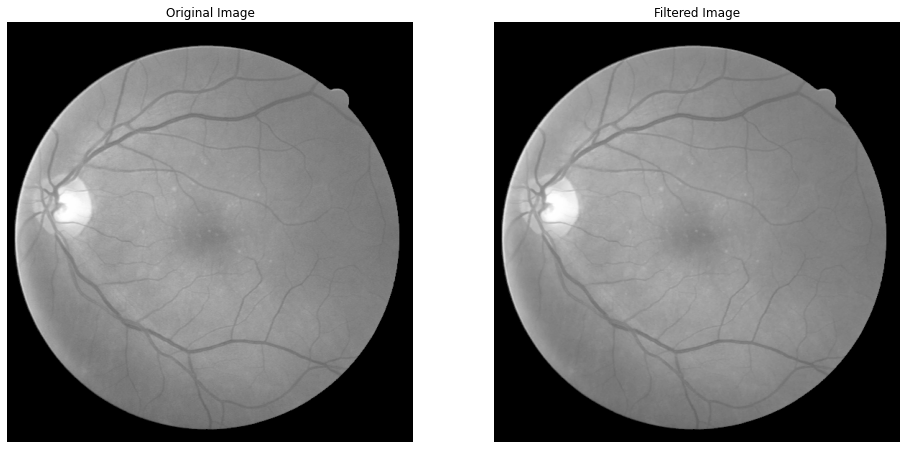

In [13]:
img = noise_reduction(img, plot)

Se normaliza la imagen:

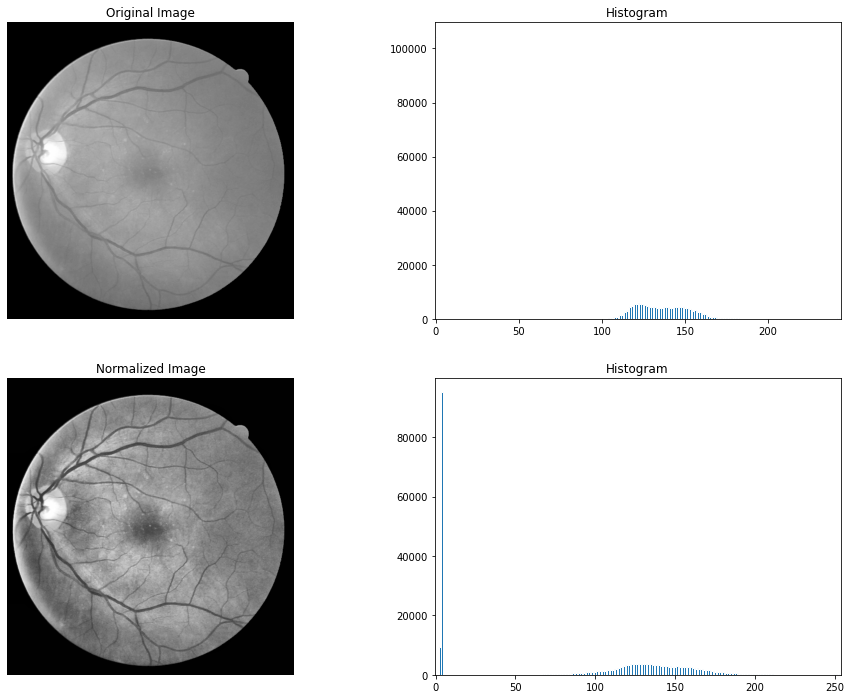

In [14]:
img = local_equalize_hist(img, plot)

Se reduce de nuevo el ruido para compensar la operación previa:

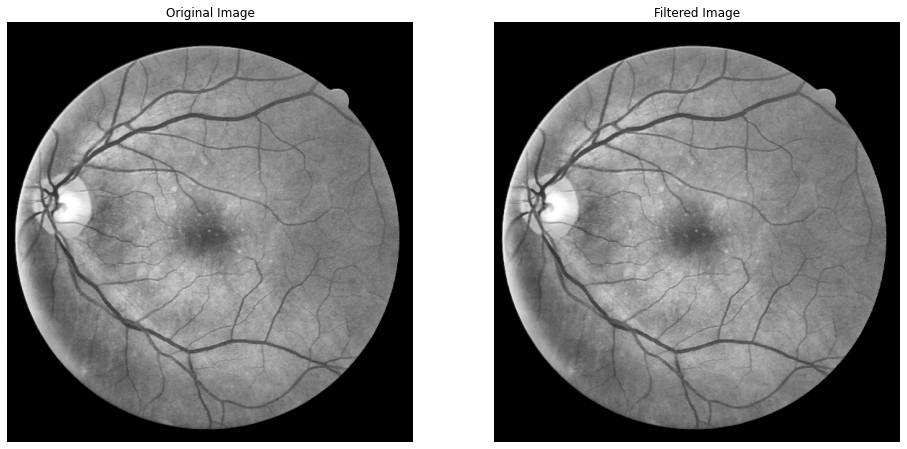

In [15]:
img = noise_reduction(img, plot)

Se aplica la operación morfológica:

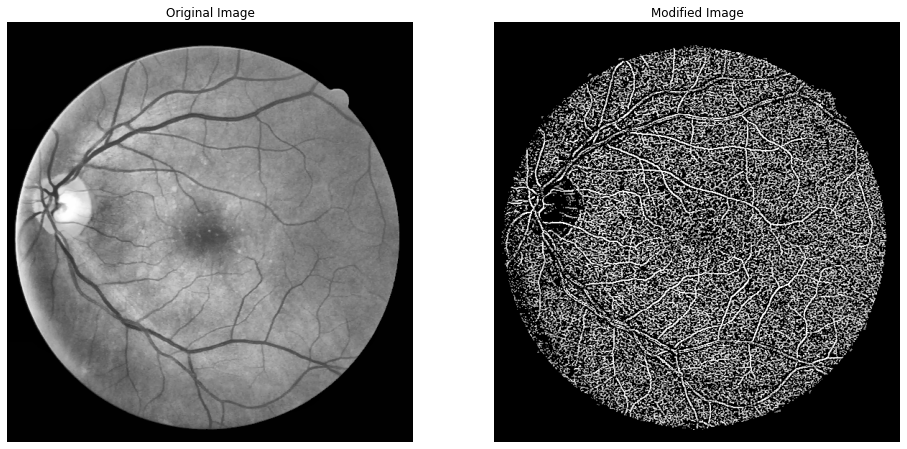

In [16]:
img = black_hat_filter(img, mask, plot)

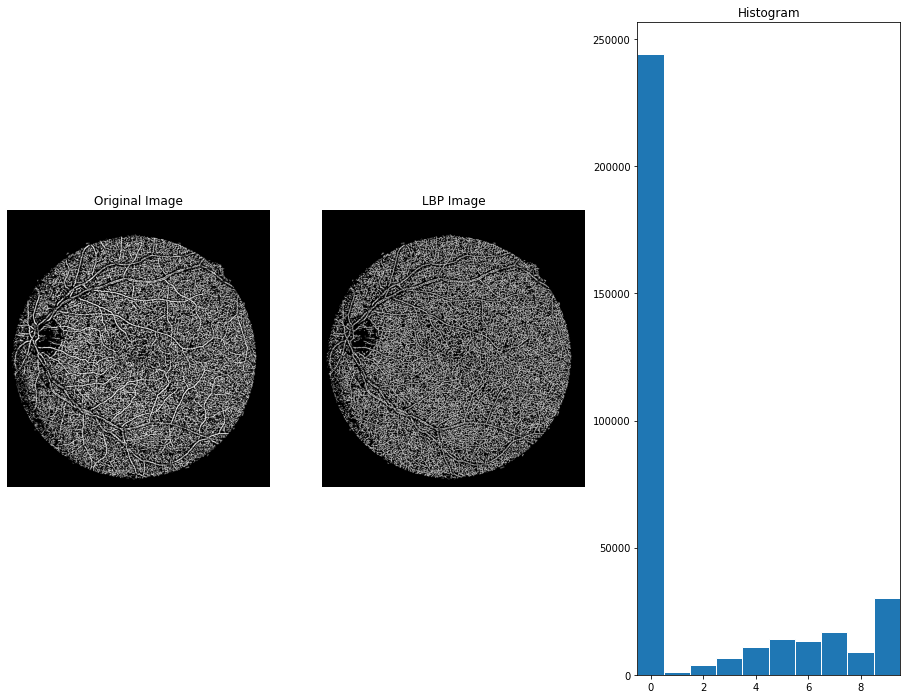

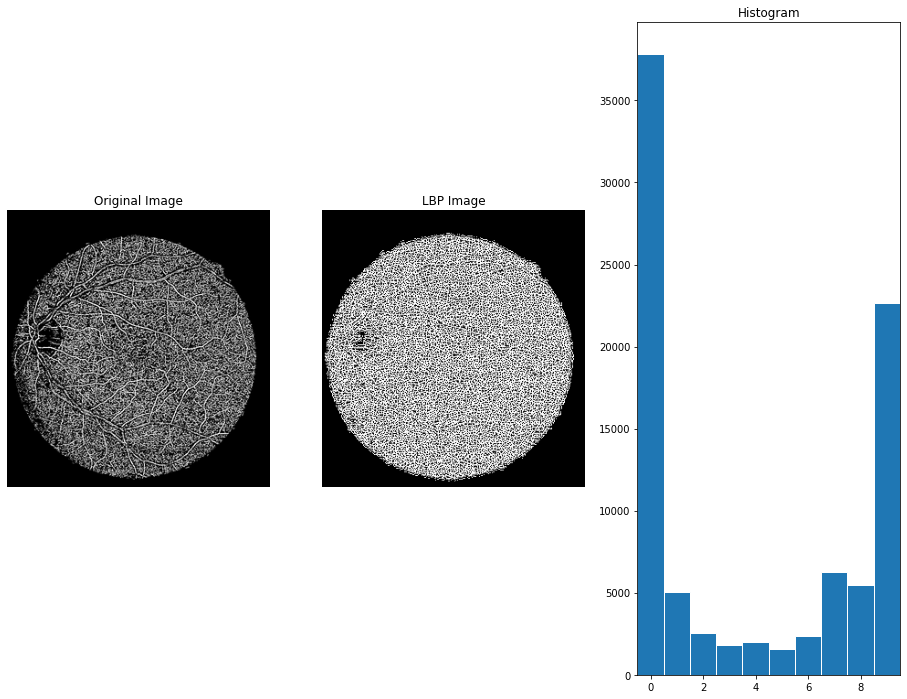

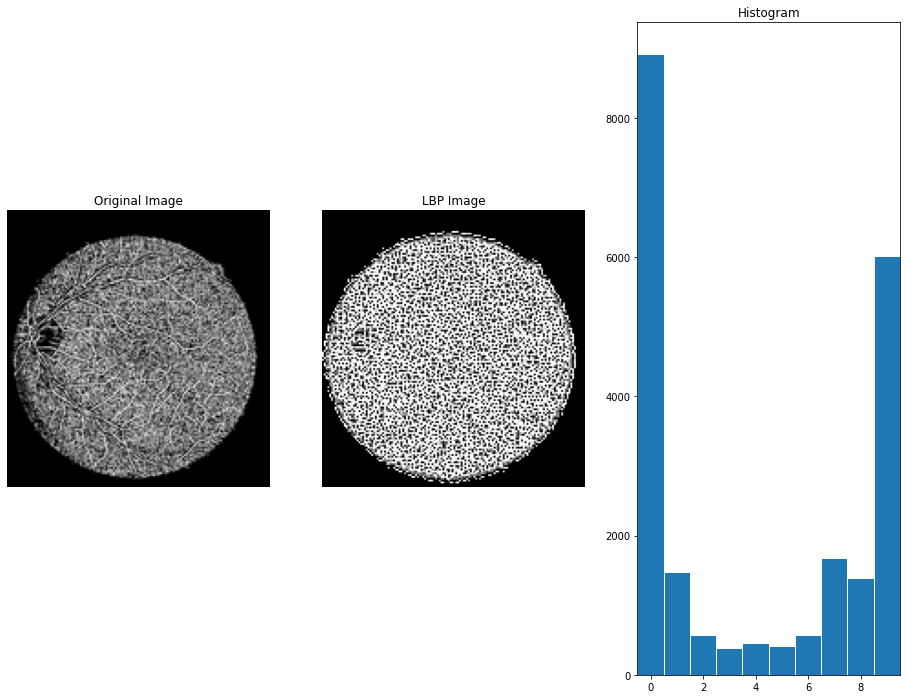

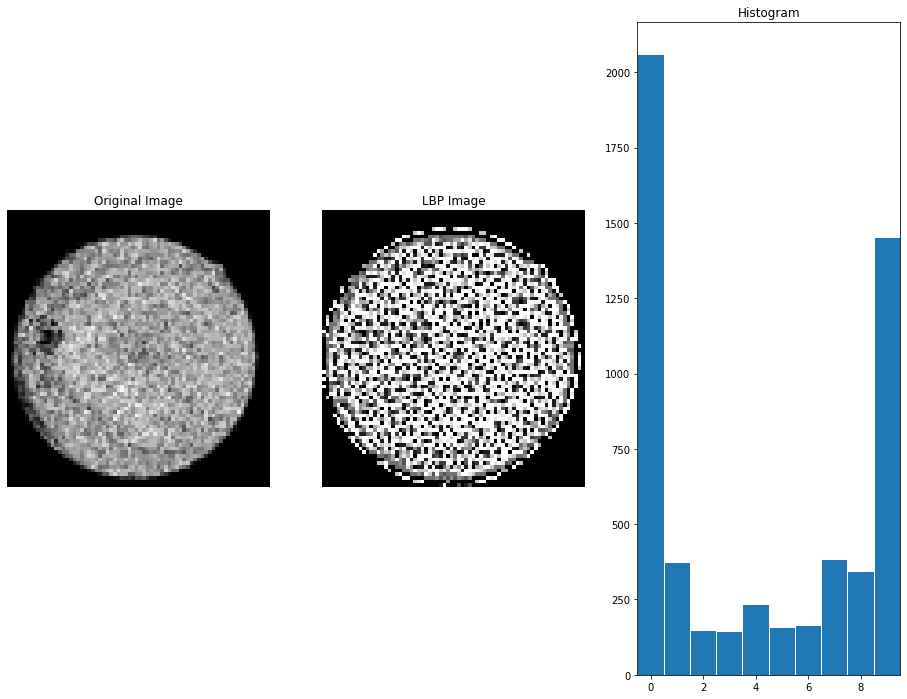

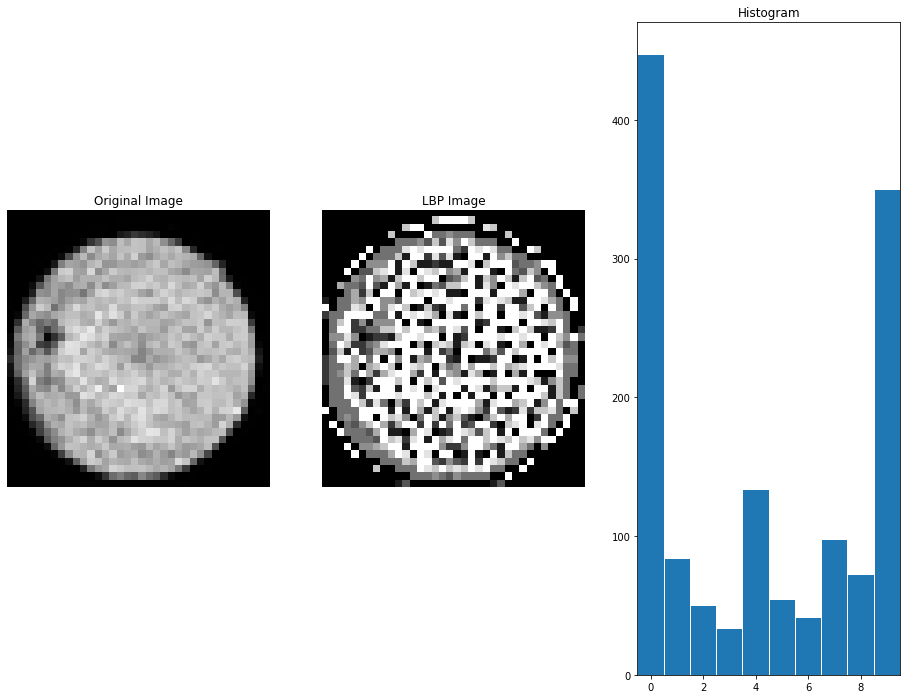

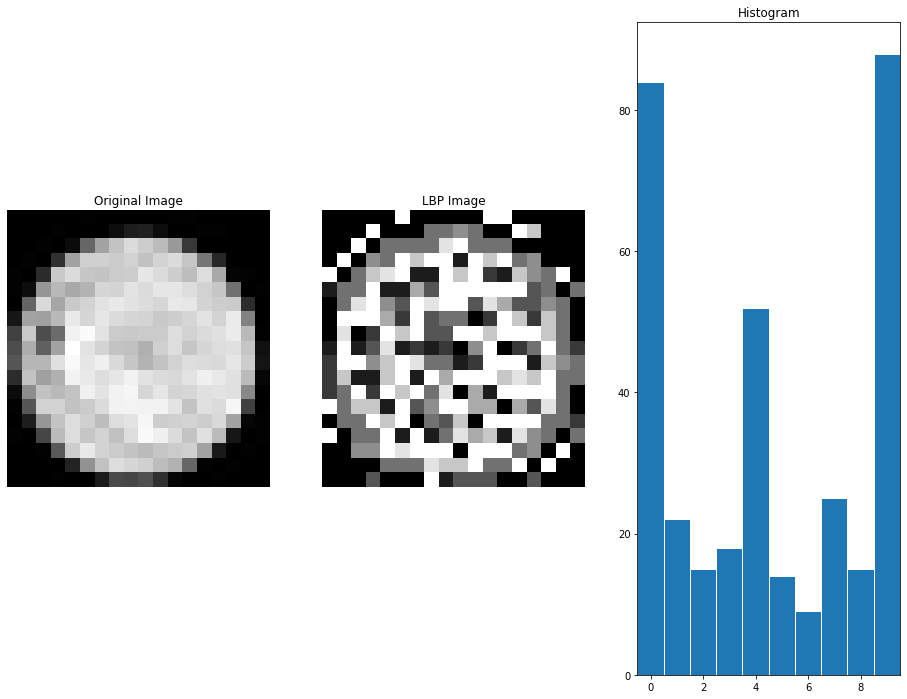

In [17]:
img = rescale_add_borders(img)
lbp_matrix = np.zeros((HEIGHT * WIDTH, 6))
for i in 2 ** np.arange(6):
    img_resized = rescale(img.copy(), (WIDTH // i, HEIGHT // i))
    img_lbp = apply_lbp(img_resized, plot=plot)
    img_lbp = repeat_pixels(img_lbp, i)
    lbp_matrix[:, int(np.log2(i))] = img_lbp.ravel()

En la matriz de información obtenida, cada fila constituye un píxel de la imagen de mayor resolución y cada columna corresponde a una resolución.

A continuación se eliminan los puntos que no forman parte de la máscara:

In [18]:
def remove_mask_data(arr, mask, remove_borders=False):
    if mask is not None:
        if remove_borders:
            mask_and_borders = rescale_add_borders(mask)
            return (arr[mask_and_borders.ravel() >= MASK_THRESHOLD, :],
                    np.where(mask_and_borders.ravel() >= MASK_THRESHOLD)[0])
        else:
            return (arr[mask.ravel() >= MASK_THRESHOLD, :],
                    np.where(mask.ravel() >= MASK_THRESHOLD)[0])
    else:
        if remove_borders:
            borders = rescale_add_borders(
                np.ones((ORIGINAL_HEIGHT, ORIGINAL_WIDTH)))
            return (arr[borders.ravel() == 1, :],
                    np.where(borders.ravel() >= MASK_THRESHOLD)[0])
        else:
            return arr, np.where(arr.ravel() >= -1)[0]

In [19]:
lbp_matrix, _ = remove_mask_data(lbp_matrix, mask, remove_borders=True)

Se añade la información de las etiquetas correspondientes a cada píxel:

In [20]:
label_path = 'jupyter-media/21_manual1.gif'

In [21]:
def get_label(path):
    img = read_img(path)
    img[img < LABEL_THRESHOLD] = 0
    img[img > LABEL_THRESHOLD] = 1
    return img

In [22]:
def plot_preprocess_with_label(img, label, mask, i=1):
    def array_to_mat(arr, mask_mat):
        mat = np.copy(mask_mat)
        mat[mat < MASK_THRESHOLD] = 0
        mat[mat >= MASK_THRESHOLD] = arr.ravel()
        return mat

    if mask is None:
        mask = np.ones((HEIGHT//i, WIDTH//i)) * MASK_THRESHOLD
    img = array_to_mat(img, mask)
    img = (img * (255 / np.max(img))).astype(int)
    label = array_to_mat(label, mask)
    img = np.asarray(Image.fromarray(np.uint8(img)).convert('RGB')).copy()
    img[label == 1] = [255, 0, 0]
    im = Image.fromarray(np.uint8(img))
    display(im)

In [23]:
if label_path is not None:
    label = get_label(label_path).reshape(-1, 1)
    label, _ = remove_mask_data(label, mask)
    lbp_matrix = np.concatenate((lbp_matrix, label), axis=1)

En la siguiente imagen se muestra una reconstrucción de la imagen LBP a escala original a partir de las posiciones de la máscara y solapando la información de los vasos sanguíneos, confirmando que todo el proceso previo ha sido realizado correctamente:

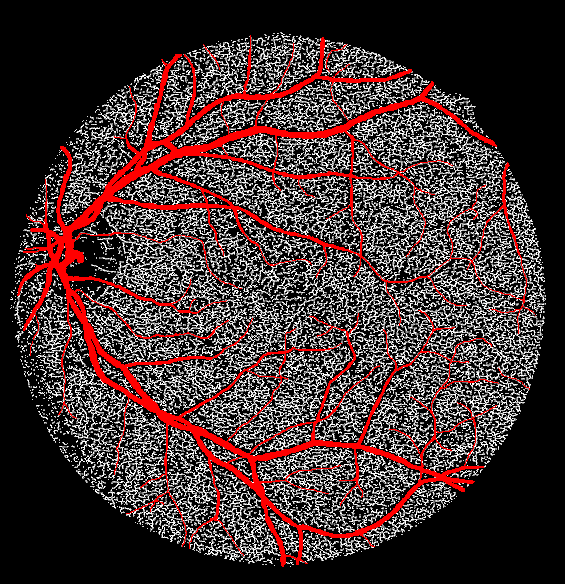

In [24]:
    plot_preprocess_with_label(lbp_matrix[:, 0], lbp_matrix[:, -1], mask)

Lo mismo ocurriría si se toma una imagen de menor resolución:

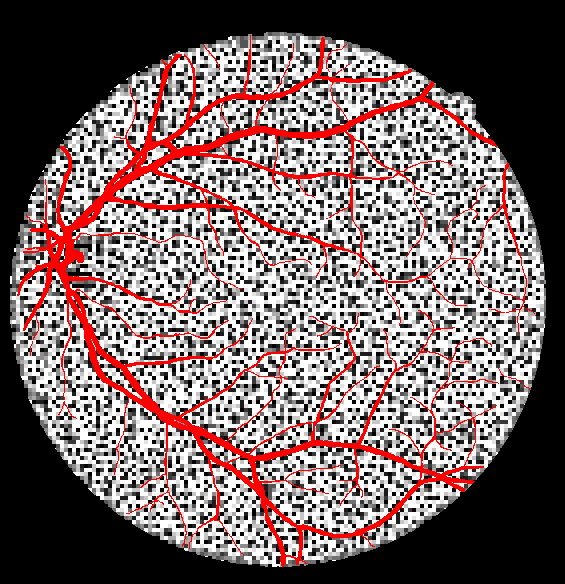

In [25]:
    plot_preprocess_with_label(lbp_matrix[:, 2], lbp_matrix[:, -1], mask)

A continuación se balancea la cantidad de información correspondiente a cada etiqueta, dejando todos los píxeles correspondientes a los vasos sanguíneos y un número igual de píxeles escogidos aleatoriamente entre los restantes. Este proceso solo se realiza en las imágenes seleccionadas a modo de entranamiento.

In [26]:
random_sample = np.random.choice(np.where(lbp_matrix[:, -1] == 0)[0],
                                 size=sum(lbp_matrix[:, -1] == 1),
                                 replace=False)
sample = np.sort(
    np.concatenate((random_sample, np.where(lbp_matrix[:, -1] == 1)[0]))
)
lbp_matrix = lbp_matrix[sample, :]

Finalmente se obtiene un DataFrame con toda la información de las diferentes escalas:

In [27]:
df = pd.DataFrame(lbp_matrix, columns=['1:1', '1:2', '1:4', '1:8', '1:16', '1:32', 'label'], dtype='uint8')

In [28]:
df.head()

,1:1,1:2,1:4,1:8,1:16,1:32,label
0,0,0,3,4,4,4,0
1,0,0,3,4,4,4,0
2,0,9,4,4,5,4,0
3,0,4,4,4,5,4,0
4,0,7,0,3,4,4,0


# Preprocesamiento de una imagen para un modelo en cada escala

El preprocesamiento realizado en el tratamiento de las imágenes de cara a obtener un conjunto de datos para realizar un modelo individual de cada escala se basa en el mismo conjunto de funciones. El proceso seguido para
cada diferente resolución es la siguiente:

In [29]:
def get_dataset_by_scale(img, mask, label, plot, train_set, i):
    img_resized = rescale(img, (WIDTH // i, HEIGHT // i))
    img_lbp = apply_lbp(img_resized, plot=plot)
    if label is not None:
        label_resized = rescale(label.copy(), (WIDTH // i, HEIGHT // i))
        if plot:
            plot_preprocess_with_label(img_lbp.reshape(-1, 1), label_resized.reshape(-1, 1), None, i=i)
        df = pd.DataFrame(np.concatenate((img_lbp.reshape(-1, 1), label_resized.reshape(-1, 1)), axis=1))
        if train_set:
            mask_resized = rescale(mask, (WIDTH // i, HEIGHT // i))
            _, selected_indexes = remove_mask_data(np.array(df), mask_resized, remove_borders=False)
            aux = np.random.choice(np.where(df.iloc[selected_indexes, -1] == 0)[0],
                                   size=sum(df.iloc[selected_indexes, -1] == 1),
                                   replace=False)
            aux = np.concatenate((aux, np.where(df.iloc[selected_indexes, -1] == 1)[0]))
            selected_indexes = selected_indexes[np.sort(aux)]
            df = df.iloc[selected_indexes, :]
        return df
    else:
        return pd.DataFrame(img_lbp.reshape(-1, 1))

De esta forma, a cada escala se le aplica el operador LBP, se calcula la correspondiente etiqueta cuando los datos son supervisados, y se obtiene un DataFrame con la información completa.

Así mismo, se realiza una diferenciación entre la información obtenida para el conjunto de entrenamiento y el de predicción. En el de entrenamiento se desea una información balanceada y estructurada de forma que pueda ser directamente aplicada para construir un modelo y que por lo tanto carezca de información considerada irrelevante como los píxeles no pertenecientes a la máscara. Es decir, no es preciso conservar una identificación de la posición real del píxel en la imágen, y por lo tanto, por ejemplo, la máscara puede ser reescalada y aplicada sin que exista ningún inconveniente en que la información no pueda ser mapeada posteriormente con respecto a la imagen original.

Sin embargo, en el caso de los datos a predecir, es imprescidible que la información procesada por el modelo pueda ser correctamente recogida y aplicada a la imagen sobre la que se está realizando una clasificación de sus píxeles y por lo tanto la información de cada escala debe ser mapeable con respecto a la imagen en resolución original, por lo que no es posible, por ejemplo, aplicar una máscara cuya resolución ha sido modificada, puesto que si se tratara de volver a las dimensiones originales el número de píxeles obtenidos para cada resolución sería diferente. Esto no supone ningún problema puesto que el modelo puede ser aplicado a cada píxel independientemente de si está considerado por la máscara y considerar posteriormente únicamente la información relevante.

Por lo tanto, la obtención de la base de datos para cada una de las imágenes se realiza en primer lugar mediante la lectura de la imagen y la anulación de los píxeles que no forman parte de la máscara, al igual que en el preprocesamiento para un único modelo, con la finalidad de simplificar los cálculos del operador LBP:

In [30]:
plot = False

img = read_img(path)
img, mask = filter_by_mask(img, mask_path)
img = noise_reduction(img, plot)
img = local_equalize_hist(img, plot)
img = noise_reduction(img, plot)
img = black_hat_filter(img, mask, plot)
img = rescale_add_borders(img)

Así mismo, se modifican las dimensiones de la máscara y la etiqueta puesto que en esta ocasión sí que verán sus dimensiones modificadas.

In [31]:
mask_and_borders = rescale_add_borders(mask)
if label_path is not None:
    label = get_label(label_path)
    label = rescale_add_borders(label)
else:
    label = None

A continuación se obtendría una lista con seis bases de datos, cada una correspondiente a la escala empleada. Si se están procesando los datos de entrenamiento tendrían la misma proporción de píxeles clasificados como vasos sanguíneos como los que no lo son, y para los datos de testeo igualmente seis bases de datos, pero conteniendo la información de la totalidad de píxeles de cada una de las resoluciones.

In [32]:
train_set = True
dfs = [get_dataset_by_scale(img.copy(), mask_and_borders.copy(), label, plot, train_set, i)
       for i in 2 ** np.arange(6)]

Finalmente se recopila la informarción de los píxeles incluidos en la máscara para el conjunto de datos que se emplearán en predicción.

In [33]:
if train_set:
    selected_indexes = None
else:
    _, selected_indexes = self.remove_mask_data(np.array(dfs[0]), mask, remove_borders=True)
data_base = {'datasets': dfs, 'mask': selected_indexes}